In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.express as px
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
db_path = "/content/drive/My Drive/ColabData/database.sqlite"  # Adjust path if needed
connection = sql.connect(db_path)
print("SQL database connected")

table = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", connection)
print(table)


SQL database connected
            name
0  NationalNames
1     StateNames


Looking through the data to see how many years of data I have for both the tables.


In [5]:
#Looking through the data to see how many years of data I have
query = """
SELECT MIN(year) AS start_year, MAX(year) AS end_year,
       (MAX(year) - MIN(year) + 1) AS total_years
FROM NationalNames;
"""
pd.read_sql(query, connection)



,start_year,end_year,total_years
0,1880,2014,135


In [6]:
query = """
SELECT MIN(year) AS start_year, MAX(year) AS end_year,
       (MAX(year) - MIN(year) + 1) AS total_years
FROM StateNames;
"""
pd.read_sql(query, connection)

,start_year,end_year,total_years
0,1910,2014,105


Firstly, lets **find the most common male name in the US during the last five years.**

In [7]:
# Find the most common boy names in US in the Last 5 years 2009 to 2014
query="""
    SELECT
        Name,
        SUM (Count) AS TotalNameCounts
    FROM NationalNames
    WHERE Year>=2009 AND Year<=2014 AND Gender='M'
    GROUP BY Name
    ORDER BY TotalNameCounts DESC
    LIMIT 10;

"""
pd.read_sql(query, connection)

,Name,TotalNameCounts
0,Jacob,117371
1,Noah,105114
2,Ethan,103936
3,William,102344
4,Michael,99816
5,Mason,98684
6,Alexander,95994
7,Jayden,95043
8,Daniel,90867
9,Aiden,88718


The table above presents the 10 most popular male names in the United States in the last 5 years from 2009 to 2014.

**Jacob** ranked as the most common male name during this time.

Lets understand that **how long it has maintained this position.**

In [8]:
query="""
    SELECT
        Name,
        Year,
        Count
    FROM NationalNames
    GROUP BY Year
    HAVING MAX(Count) AND Name='Jacob'
    LIMIT 100
"""
pd.read_sql(query, connection)

,Name,Year,Count
0,Jacob,1999,35344
1,Jacob,2000,34465
2,Jacob,2001,32527
3,Jacob,2002,30556
4,Jacob,2003,29615
5,Jacob,2004,27871
6,Jacob,2005,25814
7,Jacob,2006,24830
8,Jacob,2007,24252
9,Jacob,2008,22568


The above results have indicated that name "Jacob" became the most common in the US starting in 1999 and held that position until 2008.

Now, let's expand the timeframe and **How did popularity of the name JACOB change period-over-period nationally?**

In [9]:
query="""
WITH yearly_counts AS (
    SELECT year, SUM(count) AS total_count
    FROM NationalNames
    WHERE name = 'Jacob'
    GROUP BY year
),
yearly_change AS (
    SELECT year, total_count,
           LAG(total_count) OVER (ORDER BY year) AS prev_year_count,
           (total_count - LAG(total_count) OVER (ORDER BY year)) AS change

    FROM yearly_counts
)
SELECT * FROM yearly_change
ORDER BY year
"""
df1=pd.read_sql(query, connection)
print(df1)

     year  total_count  prev_year_count  change
0    1880          404              NaN     NaN
1    1881          381            404.0   -23.0
2    1882          390            381.0     9.0
3    1883          356            390.0   -34.0
4    1884          381            356.0    25.0
..    ...          ...              ...     ...
130  2010        22110          21171.0   939.0
131  2011        20354          22110.0 -1756.0
132  2012        19056          20354.0 -1298.0
133  2013        18094          19056.0  -962.0
134  2014        16725          18094.0 -1369.0

[135 rows x 4 columns]


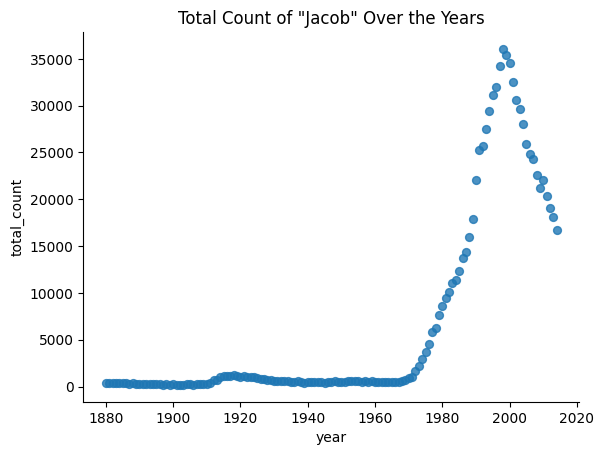

In [10]:
from matplotlib import pyplot as plt
df1.plot(kind='scatter', x='year', y='total_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Total Count of "Jacob" Over the Years')
plt.savefig('totalcount-Male.png')

In [18]:
from google.colab import files
files.download('/content/totalcount-Male.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

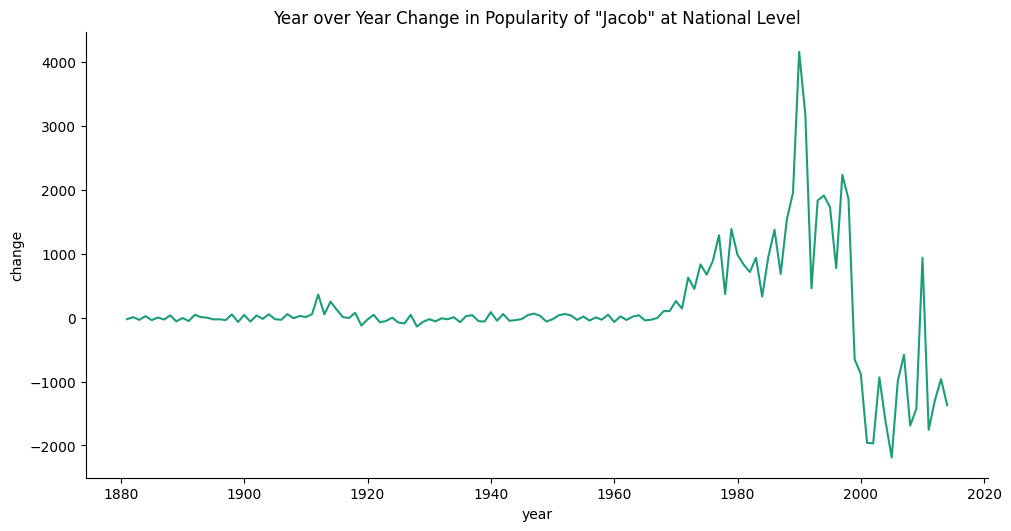

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['change']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted =df1.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('change')
plt.title('Year over Year Change in Popularity of "Jacob" at National Level')

plt.savefig('Trends-Male.png')

In [24]:
from google.colab import files
files.download('/content/Trends-Male.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Jacob** had stability before the 1960s, the sharp rise from 1970s to 2000, and the sudden decline post-2000.

Now lets understand that how these **trends were chnaged at state level** and to decide which states to analyze for the popularity of a name like Jacob. Lets start by looking at the **overall popularity of the name Jacob in different states.**

---



In [12]:
query= '''SELECT state, SUM(count) AS total_count
FROM StateNames
WHERE name = 'Jacob'
GROUP BY state
ORDER BY total_count DESC;
'''
pd.read_sql(query, connection)

,State,total_count
0,CA,94627
1,TX,70518
2,NY,42936
3,OH,42802
4,IL,39240
5,MI,37631
6,PA,35946
7,FL,33138
8,IN,24996
9,NC,23527


CA and TX are the clear winner in terms of popularity of name Jacob.

**Now, Lets try to understand the popularity pattern over the years in these two states and observe that does that mirror nations wide trends or not.**

In [13]:
query= '''WITH yearly_counts AS (
    SELECT state, year, SUM(count) AS total_count
    FROM StateNames
    WHERE name = 'Jacob' AND state IN ('CA', 'TX', 'NY')
    GROUP BY state, year
),
yearly_change AS (
    SELECT state, year, total_count,
           LAG(total_count) OVER (PARTITION BY state ORDER BY year) AS prev_year_count,
           (total_count - LAG(total_count) OVER (PARTITION BY state ORDER BY year)) AS change
    FROM yearly_counts
)
SELECT * FROM yearly_change
ORDER BY state, year;
'''
df=pd.read_sql(query, connection)
print(df)


    state  year  total_count  prev_year_count  change
0      CA  1912            7              NaN     NaN
1      CA  1913           11              7.0     4.0
2      CA  1914            6             11.0    -5.0
3      CA  1915           10              6.0     4.0
4      CA  1916            9             10.0    -1.0
..    ...   ...          ...              ...     ...
306    TX  2010         2271           1999.0   272.0
307    TX  2011         2043           2271.0  -228.0
308    TX  2012         1949           2043.0   -94.0
309    TX  2013         1967           1949.0    18.0
310    TX  2014         1841           1967.0  -126.0

[311 rows x 5 columns]


Text(0.5, 1.0, 'Year over Year Change in Popularity at State Level')

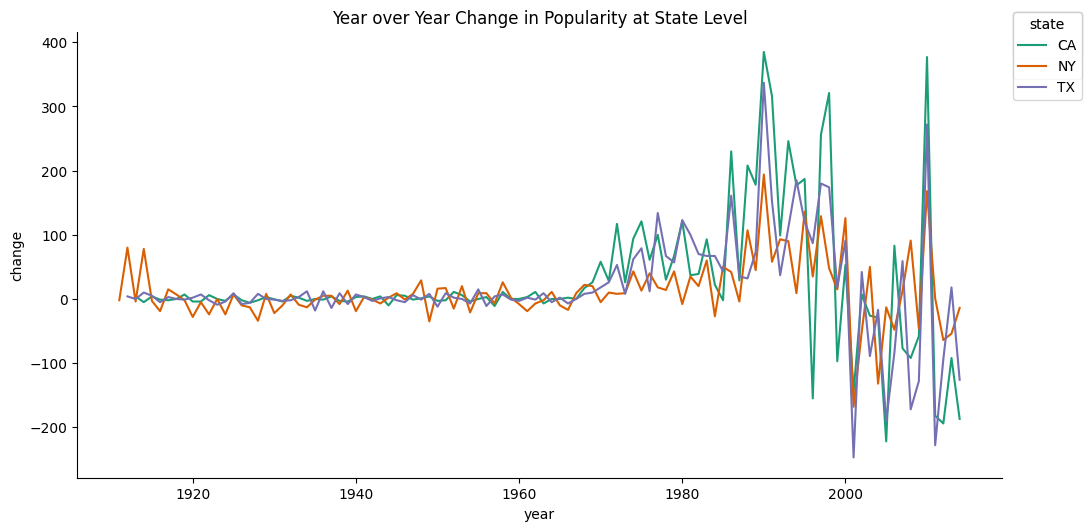

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['change']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('state')):
  _plot_series(series, series_name, i)
  fig.legend(title='state', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('change')
plt.title('Year over Year Change in Popularity at State Level')

Now lets combine the national and state level trends in a same graph and understand trends.

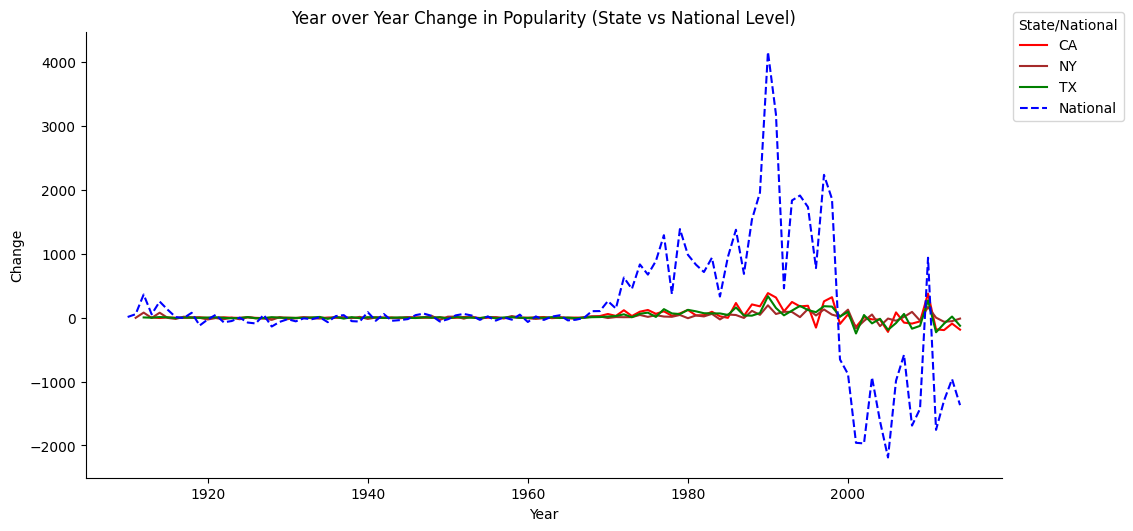

<Figure size 640x480 with 0 Axes>

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, color, linestyle='-'):
    """Helper function to plot a single series with specified color."""
    xs = series['year']
    ys = series['change']

    plt.plot(xs, ys, label=series_name, color=color, linestyle=linestyle)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Define colors for state-level and national-level data
state_colors = ['red', 'brown', 'green']  # Colors for two states (modify if needed)
national_color = 'blue'          # Color for national trend

# Plot state-level data
df_sorted = df.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('state')):
    color = state_colors[i % len(state_colors)]  # Cycle through state colors
    _plot_series(series, series_name, color, linestyle='-')

# Plot national-level data with blue color and dashed line
df1_filtered = df1[df1['year'] >= 1910]  # Filter years >= 1900
df1_sorted = df1_filtered.sort_values('year', ascending=True)
_plot_series(df1_sorted, 'National', national_color, linestyle='--')

# Formatting and labels
fig.legend(title='State/National', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
plt.ylabel('Change')
plt.title('Year over Year Change in Popularity (State vs National Level)')

plt.show()
plt.savefig('TrendsStates-Male.png')

In [33]:
from google.colab import files
files.download('/content/TrendsStates-Male.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The overall trend in California, Texas and NewYork follows the national trend, meaning that the popularity changes in these states reflect broader national patterns. This also suggests that national factors (e.g., media, cultural trends, famous personalities, or events) influence naming trends at the state level.

However, following are the detailed insights about the above analysis:

Nationwide Trend Mirrors CA & TX Patterns

1.   **Nationwide Trend Mirrors CA, TX & NY Patterns:** The second graph provides a nationwide perspective on the year-over-year popularity change for the name Jacob, confirming that its trend in California (CA), New York (NY) and Texas (TX),  was part of a broader national pattern. The overall trajectory aligns closely with the state-level trends, remaining stable before the 1960s, experiencing rapid growth from the 1970s to 2000, and then declining sharply after 2000. The steep rise in popularity between the 1970s and 2000s corresponds to Jacob's reign as the most popular baby boy name in the U.S. for over a decade (1999–2012), showing that it was a widespread cultural phenomenon rather than a localized trend.

2.   **Decline After 2000 & Business Implications:** After peaking around 2000, Jacob’s popularity began to decline sharply, a pattern that is even more pronounced in the national graph than in CA, TX and NY. Several factors likely contributed to this decline, including cultural shifts favoring newer names like Noah, Liam, and Mason, the overuse factor leading parents to seek less common names, and changing pop culture influences. This confirms that Jacob is now a declining trend, suggesting that businesses offering name-based personalization should focus on emerging popular names rather than ones that have peaked and are falling out of favor.


Lets analyze the naming trends in female by repeating the same analysis that we performed above for the male names.

In [16]:
# Find the most common girl names in US in the Last 5 years 2009 to 2014
query="""
    SELECT
        Name,
        SUM (Count) AS TotalNameCounts
    FROM NationalNames
    WHERE Year>=2009 AND Year<=2014 AND Gender='F'
    GROUP BY Name
    ORDER BY TotalNameCounts DESC
    LIMIT 10;

"""
pd.read_sql(query, connection)

,Name,TotalNameCounts
0,Sophia,121257
1,Isabella,118612
2,Emma,116557
3,Olivia,107043
4,Ava,93068
5,Emily,83103
6,Abigail,78842
7,Madison,72930
8,Mia,72097
9,Chloe,61460


The table above presents the 10 most popular female names in the United States in the last 5 years from 2009 to 2014.

**Sophia** ranked as the most common male name during this time.

**Lets understand that how long it has maintained this position?**

In [17]:
# the query was performed for all the top 10 names, "Sophia", "Isabella", "Emma", "Olivia","Ava", "Emily", "Abigail" etc.

query="""
    SELECT
        Name,
        Year,
        Count
    FROM NationalNames
    GROUP BY Year
    HAVING MAX(Count) AND Name='Sophia'
    LIMIT 10
"""

pd.read_sql(query, connection)

,Name,Year,Count
0,Sophia,2011,21816
1,Sophia,2012,22267
2,Sophia,2013,21147


"Sophia" is the only name who has shown trends in the last few years.

---





Now lets **compare the national ranking of a name with its ranking in specific states like Texas (TX) and California (CA) to understand the regional trends in more depth.**

In [19]:
query= '''SELECT name, SUM(count) AS total_usage
FROM NationalNames
GROUP BY name
ORDER BY total_usage DESC
LIMIT 10;

'''
pd.read_sql(query,connection)

,Name,total_usage
0,James,5129096
1,John,5106590
2,Robert,4816785
3,Michael,4330805
4,Mary,4130441
5,William,4071368
6,David,3590557
7,Joseph,2580687
8,Richard,2564867
9,Charles,2376700


the following query list the top names in different states.

In [18]:
query= '''SELECT name, SUM(count) AS total_usage
FROM StateNames
WHERE state = 'TX'
GROUP BY name
ORDER BY total_usage DESC
LIMIT 10;
'''
pd.read_sql(query,connection)

,Name,total_usage
0,James,273998
1,John,236229
2,Michael,226829
3,Robert,221040
4,David,220590
5,Mary,210119
6,William,174449
7,Jose,158921
8,Christopher,145434
9,Maria,131473


In [20]:
query= '''SELECT name, SUM(count) AS total_usage
FROM StateNames
WHERE state = 'CA'
GROUP BY name
ORDER BY total_usage DESC
LIMIT 10;
'''
pd.read_sql(query,connection)

,Name,total_usage
0,Michael,424585
1,David,366353
2,Robert,348971
3,John,311263
4,James,275235
5,Daniel,245425
6,Richard,223523
7,Christopher,216833
8,William,209819
9,Anthony,175025


Now lets **find names that are top 10 nationally but not in the top 10 in TX or CA and compare the national rankings with state rankings and filters out names that are missing from the top 10 in TX and CA.**

In [21]:
query='''WITH NationalTop AS (
    SELECT name, SUM(count) AS total_usage
    FROM NationalNames
    GROUP BY name
    ORDER BY total_usage DESC
    LIMIT 10
),
TexasTop AS (
    SELECT name
    FROM StateNames
    WHERE state = 'TX'
    GROUP BY name
    ORDER BY SUM(count) DESC
    LIMIT 10
),
CaliforniaTop AS (
    SELECT name
    FROM StateNames
    WHERE state = 'CA'
    GROUP BY name
    ORDER BY SUM(count) DESC
    LIMIT 10
)
SELECT n.name
FROM NationalTop n
LEFT JOIN TexasTop t ON n.name = t.name
LEFT JOIN CaliforniaTop c ON n.name = c.name
WHERE t.name IS NULL OR c.name IS NULL;
'''
pd.read_sql(query,connection)


,name
0,Mary
1,Joseph
2,Richard
3,Charles


**Insights:** The results reveal that while Mary, Joseph, Richard, and Charles are among the most popular names nationally, they do not rank in the top 10 in either Texas (TX) or California (CA). This suggests that naming preferences in these states differ from the national trend, possibly due to cultural, demographic, or regional influences. For a new bussiness selling personalized baby clothing, this insight is valuable—it indicates that a **one-size-fits-all marketing approach may not be effective**. Instead, the company should consider regionalized product recommendations and targeted marketing strategies that reflect local naming trends, ensuring higher engagement and sales in different states.

In [26]:
query='''
WITH NationalCounts AS (
    SELECT name, SUM(count) AS national_count
    FROM NationalNames
    WHERE name IN ('Mary', 'Joseph', 'Richard', 'Charles')
    GROUP BY name
),
StateCounts AS (
    SELECT name, state, SUM(count) AS state_count
    FROM StateNames
    WHERE name IN ('Mary', 'Joseph', 'Richard', 'Charles')
    AND state IN ('TX', 'CA')
    GROUP BY name, state
)
SELECT
    nc.name,
    nc.national_count,
    sc.state AS state,
    sc.state_count
FROM NationalCounts nc
LEFT JOIN StateCounts sc
    ON nc.name = sc.name
ORDER BY nc.national_count DESC, sc.state;
'''
pd.read_sql(query,connection)


,name,national_count,state,state_count
0,Mary,4130441,CA,152533
1,Mary,4130441,TX,210119
2,Joseph,2580687,CA,170838
3,Joseph,2580687,TX,90153
4,Richard,2564867,CA,223523
5,Richard,2564867,TX,110176
6,Charles,2376700,CA,110265
7,Charles,2376700,TX,127013


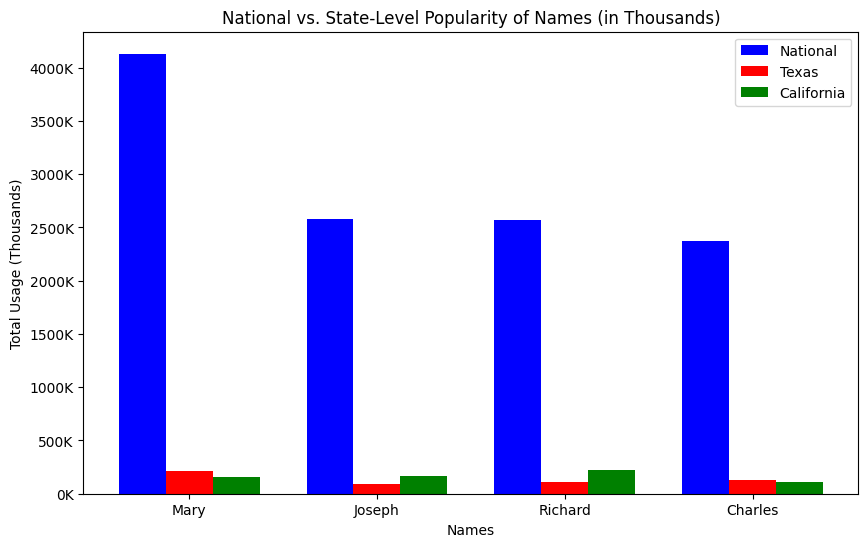

In [28]:
import numpy as np


names = ["Mary", "Joseph", "Richard", "Charles"]
national_counts = [4130441, 2580687,2564867,2376700]
texas_counts = [210119, 90153, 110176, 127013]
california_counts = [152533, 170838, 223523, 110265]



national_counts = np.array(national_counts) / 1000
texas_counts = np.array(texas_counts) / 1000
california_counts = np.array(california_counts) / 1000


x = np.arange(len(names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, national_counts, width, label='National', color='blue')
bars2 = ax.bar(x, texas_counts, width, label='Texas', color='red')
bars3 = ax.bar(x + width, california_counts, width, label='California', color='green')

ax.set_xlabel("Names")
ax.set_ylabel("Total Usage (Thousands)")
ax.set_title("National vs. State-Level Popularity of Names (in Thousands)")
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}K'))

plt.show()

In order to expand our analysis Now lets see that **which is the most popular unisex name to understand changing perceptions of gender identity in names.**




In [18]:
query='''
WITH NameCounts AS (
    SELECT
        name,
        gender,
        SUM(count) AS total_count
    FROM NationalNames
    GROUP BY name, gender
),
GenderRatios AS (
    SELECT
        n1.name,
        SUM(CASE WHEN n1.gender = 'M' THEN n1.total_count ELSE 0 END) AS male_count,
        SUM(CASE WHEN n1.gender = 'F' THEN n1.total_count ELSE 0 END) AS female_count,
        SUM(n1.total_count) AS total_usage
    FROM NameCounts n1
    JOIN NameCounts n2
        ON n1.name = n2.name
        AND n1.gender <> n2.gender
    GROUP BY n1.name
)
SELECT
    name,
    male_count,
    female_count,
    total_usage
FROM GenderRatios
ORDER BY total_usage DESC
LIMIT 10;
'''
pd.read_sql(query,connection)

,name,male_count,female_count,total_usage
0,James,5105919,23177,5129096
1,John,5084943,21647,5106590
2,Robert,4796695,20090,4816785
3,Michael,4309198,21607,4330805
4,Mary,15159,4115282,4130441
5,William,4055473,15895,4071368
6,David,3577704,12853,3590557
7,Joseph,2570095,10592,2580687
8,Richard,2555330,9537,2564867
9,Charles,2364332,12368,2376700


the above table indicates that **James** and **John** are most common unisex name.

---



**Let explore how can we use nationally popular but locally rare names to helps understand name diversity across states?**

In [19]:
query='''
WITH NationalPopularity AS (
    SELECT
        name,
        SUM(count) AS national_count
    FROM NationalNames
    GROUP BY name
),
StateMaxPopularity AS (
    SELECT
        name,
        MAX(count) AS max_state_count
    FROM StateNames
    GROUP BY name
)
SELECT
    n.name,
    n.national_count,
    s.max_state_count
FROM NationalPopularity n
JOIN StateMaxPopularity s ON n.name = s.name
ORDER BY n.national_count DESC
LIMIT 10;
'''
pd.read_sql(query,connection)


,name,national_count,max_state_count
0,James,5129096,7174
1,John,5106590,9634
2,Robert,4816785,10023
3,Michael,4330805,9250
4,Mary,4130441,8184
5,William,4071368,6273
6,David,3590557,8118
7,Joseph,2580687,4953
8,Richard,2564867,7153
9,Charles,2376700,3166


The above results shows that 'James' has 5,129,096 people nationwide with the name, but in the state with the highest count (probably a state with a large population), only 7,174 people have the name. This shows that while the name is popular across the entire country, it is relatively less common in any one state compared to the national total.
The pattern shows that these names are quite prevalent across the country but don't dominate any specific state's population. This suggests that these names might be more evenly distributed across different states or might be outnumbered by other popular names at the state level.

 **Insights:** This helps understand name diversity across states, useful for demographic studies and inclusive marketing strategies.

Now lets explore the following 2 questions to help the business differentiate themselves by catering to niche markets.

1.   **Are there gender neutral naming trends in recent years at national level?**
2.  **Can we identify emerging names beyond the top 10 by analyzing increasing yearly trends to target niche market?**




In [20]:
query='''
SELECT
    name,
    AVG(CASE WHEN gender = 'M' THEN count ELSE 0 END) AS avg_male_count,
    AVG(CASE WHEN gender = 'F' THEN count ELSE 0 END) AS avg_female_count,
    COUNT(DISTINCT year) AS years_counted
FROM
    NationalNames
WHERE
    gender IN ('M', 'F')
    AND year >= 2009
GROUP BY
    name
HAVING
    ABS(avg_male_count - avg_female_count) < 0.2 * (avg_male_count + avg_female_count)
ORDER BY
    years_counted DESC;
'''
pd.read_sql(query,connection)

,Name,avg_male_count,avg_female_count,years_counted
0,Abrar,7.583333,10.833333,6
1,Abriel,12.500000,9.333333,6
2,Adama,7.416667,8.583333,6
3,Adi,12.250000,14.916667,6
4,Aideen,3.400000,4.800000,6
...,...,...,...,...
498,Rhyon,4.500000,3.500000,1
499,Robi,2.500000,2.500000,1
500,Taiwo,2.500000,2.500000,1
501,Yahav,2.500000,2.500000,1


Following are the insights that we can take from the results.


1.   **Gender-Neutral Trends:** Names like "Robi," "Taiwo," and "Yiran," which have equal counts for both genders, suggest a move toward more gender-neutral names in recent years. The more similar the counts are between male and female genders, the more neutral the name is.Therefore, there should  be focus on personalized clothing based on names, and consider marketing products for gender-neutral names. May be creating a unique product line targeting gender-neutral individuals.

2.   **Popular Gender-Specific Names:** Although the Names like Jacob is the most popular name in the US however its popularity has declined (confirmed from the above analsis). However the name like "Jacob" "Adi" or "Abriel" have higher counts for one gender, indicating these may be more gender-specific names.These names could be good candidates for targeted marketing based on gender preferences. For example, the bussiness could offer different clothing designs or categories based on gendered trends.

**Final Thoughts:**

**Consistency of Popularity:** Names with high years_counted (e.g., 6 years) indicate that they have sustained popularity over time, whereas names with only 1 year of data might be more trendy or emerging. A focus on names with consistent popularity might help the bussiness to target a broader, longer-term market. Alternatively, focusing on emerging names (those with fewer years counted) could attract customers interested in more unique or trendy items.

**Market Segmentation:** By analyzing names that are popular across both genders and those that are more gender-specific, the bussiness can better segment its marketing efforts and can tailor products or campaigns based on the prevalence of certain names in specific demographics.

**Business Insight:** Personalization is key—if bussiness offer customized clothing, ensuring that the designs are inclusive of both gendered and gender-neutral names will widen the appeal. This may also inform how to present bussiness branding, whether through subtle customization for more popular names or offering exclusive lines for unique, trendy names.